# Tutorial 2: Reset and Step

In this tutorial, we will show how to create a gym environment using [EAGERx](https://eagerx.readthedocs.io/en/master/).
Here we go a bit deeper into the [step()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.step) and [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.reset) methods.

The following will be covered:
- Extracting observations in the [step()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.step) method.
- Resetting states using the [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.EagerxEnv.reset) method.
- The `window` argument of the [connect method](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect#eagerx.core.graph.Graph.connect)
- Simulating delays using the `delay` argument of the [connect()](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect#eagerx.core.graph.Graph.connect) method.

In the remainder of this tutorial, we will go more into detail on these concepts.

Furthermore, at the end of this notebook you will find exercises.
For the exercises you will have to add/modify a couple of lines of code, which are marked by

```python

# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

## Pendulum Swing-up

We will create an environment for solving the classic control problem of swinging up an underactuated pendulum, very similar to the [Pendulum-v1 environment](https://www.gymlibrary.ml/environments/classic_control/pendulum/).
Our goal is to swing up this pendulum to the upright position and keep it there, while minimizing the velocity of the pendulum and the input voltage.

Since the dynamics of a pendulum actuated by a DC motor are well known, we can simulate the pendulum by integrating the corresponding ordinary differential equations (ODEs):


$\mathbf{x} = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} \\ \dot{\mathbf{x}} = \begin{bmatrix} \dot{\theta} \\ \frac{1}{J}(\frac{K}{R}u - mgl \sin{\theta} - b \dot{\theta} - \frac{K^2}{R}\dot{\theta})\end{bmatrix}$

with $\theta$ the angle w.r.t. upright position, $\dot{\theta}$ the angular velocity, $u$ the input voltage, $J$ the inertia, $m$ the mass, $g$ the gravitational constant, $l$ the length of the pendulum, $b$ the motor viscous friction constant, $K$ the motor constant and $R$ the electric resistance.



## Activate GPU (Colab only)

When in Colab, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

## Notebook Setup

In order to be able to run the code, we need to install the *eagerx_tutorials* package.

In [ ]:
try:
    import eagerx_tutorials
except ImportError:
    if "google.colab" in str(get_ipython()):
        !pip install gymnasium[classic-control]==1.2.0
        print("Installing pybullet with pip.")
        import gdown
        gdown.download(id="15IKv71tEK11p1B6iZ1HX8r_MY2ibcS_h", quiet=True)
        !pip install pybullet-3.2.5-cp310-cp310-linux_x86_64.whl >> /tmp/pybullet_install.txt 2>&1
    !{"echo 'Installing eagerx-tutorials with pip.' && pip install eagerx-tutorials >> /tmp/eagerx_install.txt 2>&1"}

# Setup interactive notebook
# Required in interactive notebooks only.
from eagerx_tutorials import helper
helper.setup_notebook()

# Import eagerx
import eagerx
eagerx.set_log_level(eagerx.WARN)

Not running on CoLab.


## Let's get started

Next, we make the specification for a *Pendulum* object and add it to an empty graph, just like we did in the [first tutorial](https://colab.research.google.com/github/eager-dev/eagerx_tutorials/blob/master/tutorials/pendulum/1_environment_creation.ipynb).

We will again connect the *u* actuator of the *Pendulum* to an action that we will call *voltage* and connect the sensors *theta* and *theta_dot* to observations, which we will call *angle* and *angular_velocity*.
However, we will now go a bit more into detail on the [connect method](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect#eagerx.core.graph.Graph.connect).
When connecting outputs, sensors or actions, we can specify among other things the `window` of the connection.
It specifies how to deal with messages that are sent between nodes in between calls to their callback.
In some cases it makes sense to use the last one only; in others you would like to receive all messages between calls.
This can be achieved by setting the `window` size:

- `window` $= 1$: Only the last received input message are available to the receiver.
- `window` $= x \ge 1$: The trailing last $x$ received input messages are available to the receiver ($1 \le$ received number of messages $\le$ `window` ).
- `window` $= 0$: All input messages received since the last call to the node's callback are available.

This is in particular relevant when connecting to observations, since it has consequences for the size of the observation space.
When connecting to an observation with `window` $= 0$, this observation will **not by default** be included in the observation space of the agent, because its dimensions might change every time step and are therefore unknown beforehand. You can, however, always decide to add the observation manually to the space in the Gym environment definiton.
Also worth noting, is that for observations with `window` $= x > 1$, at time step $t < x$, the first message is repeated $x - t$ times to ensure that the dimensions of the observation space is consistent.

Besides the `window` size, we can also specify a `delay` for each connection.
In this way, we can easily simulate delays for inputs and sensors.


In [2]:
# Define rate (Hz)
rate = 30.0

# Initialize empty graph
graph = eagerx.Graph.create()

# Make pendulum
from eagerx_tutorials.pendulum.objects import Pendulum

# START EXERCISE 1.1
# Remove sensor theta_dot from and add sensor u_applied to the list of sensors.  
# sensors = ["theta", "theta_dot", "image"]
sensors = ["theta", "image", "u_applied"]  # Solution
# END EXERCISE 1.1

# START EXERCISE 2.1
# Add the state model_parameters to the list of states of the pendulum. 
# states = ["model_state"]
states = ["model_state", "model_parameters"]  # Solution
# END EXERCISE 2.1

pendulum = Pendulum.make("pendulum", actuators=["u"], sensors=sensors, states=states)

# Add pendulum to the graph
graph.add(pendulum)

# Connect the pendulum to an action and observation
# We will now explicitly set the window size
graph.connect(action="voltage", target=pendulum.actuators.u, window=1)

# START EXERCISE 1.2 & 1.3
# 1.2 Remove the connection from sensor theta_dot. 
# 1.3 Also, connect sensor theta with window=3 to stack the last three observations of theta and set delay to 0.01.
# graph.connect(source=pendulum.sensors.theta, observation="angle", window=1)
# graph.connect(source=pendulum.sensors.theta_dot, observation="angular_velocity", window=1)
graph.connect(source=pendulum.sensors.theta, observation="angle", window=3, delay=0.01)  # Solution
# END EXERCISE 1.2

# START EXERCISE 1.4
# Connect u_applied to an observation called voltage_applied with window=1.
# Do you know why u_applied should be an observation to the agent in order to restore the Markov property?
graph.connect(source=pendulum.sensors.u_applied, observation="voltage_applied", window=1)  # Solution
# END EXERCISE 1.4

# Render image
graph.render(source=pendulum.sensors.image, rate=rate)

# Make OdeEngine
from eagerx_ode.engine import OdeEngine
engine = OdeEngine.make(rate=rate)

Using the [*eagerx_gui* package](https://github.com/eager-dev/eagerx_gui), we can again visualize the graph.

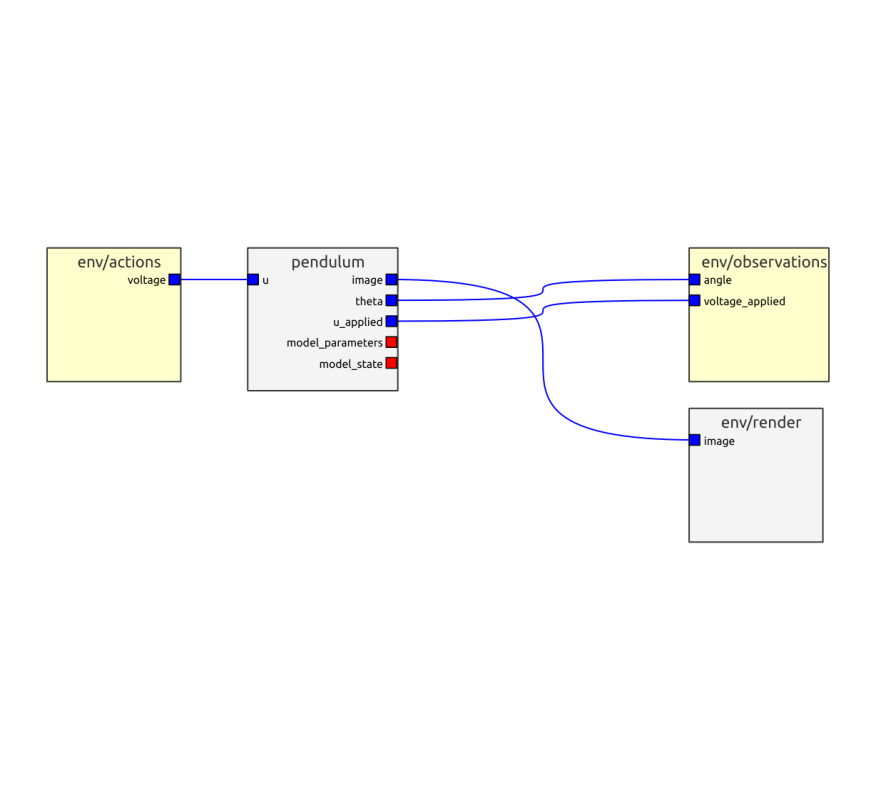

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

gui_render = graph.gui(interactive=False)
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis("off")
plt.imshow(gui_render)

Next, we will create the [Environment](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html).
We will now define the [step()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.step) method.
Here we define the `reward` and fill the `info` dictionary at each time step.
Since we want to stabilize the pendulum in upright position — while minimising the input voltage — we define the reward to be a weighted sum of $\theta^2$, $\dot{\theta^2}$ and $u^2$.

We will elaborate a bit more on this step function.
The keys of observations and dictionaries correspond to respectively the value of the `observation` and `action` argument provided in the [connect method](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect#eagerx.core.graph.Graph.connect).
Note that inside the step method we call `self._step(action)` to get the observations.

The [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html#eagerx.core.env.BaseEnv.reset) should also be defined by the user.
The reset function allows to specify how states are reset at the beginning of an episode.
Remember that we have one object (*Pendulum*) with one state (*model_state*).
This *model_state* corresponds to $\mathbf{x} = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix}$.

We will define the reset function such that it will reset the pendulum at the beginning of an episode to $\mathbf{x} = \begin{bmatrix} \pi \\ 0 \end{bmatrix}$.
This corresponds to the downward position with zero velocity.
Note that we call `self._reset(states)` to perform the actual reset and to obtain the new observation.

In [4]:
from typing import Dict
import numpy as np


class PendulumEnv(eagerx.BaseEnv):
    def __init__(self, name: str, rate: float, graph: eagerx.Graph, engine: eagerx.specs.EngineSpec, render_mode: str = "human"):
        """Initializes an environment with EAGERx dynamics.

        :param name: The name of the environment. Everything related to this environment
                     (parameters, topics, nodes, etc...) will be registered under namespace: "/[name]".
        :param rate: The rate (Hz) at which the environment will run.
        :param graph: The graph consisting of nodes and objects that describe the environment's dynamics.
        :param engine: The physics engine that will govern the environment's dynamics.
        :param render_mode: Defines the render mode (e.g. "human", "rgb_array").
        """
        # Make the backend specification
        from eagerx.backends.single_process import SingleProcess
        backend = SingleProcess.make()
        
        self.eval = eval
        
        # Maximum episode length
        self.max_steps = 100
        
        # Step counter
        self.steps = None
        super().__init__(name, rate, graph, engine, backend, force_start=True, render_mode=render_mode)
    
    def step(self, action: Dict):
        """A method that runs one timestep of the environment's dynamics.

        :params action: A dictionary of actions provided by the agent.
        :returns: A tuple (observation, reward, terminated, truncated, info).

              - observation: Observations of the current timestep that comply with
                             the :func:`~eagerx.core.env.BaseEnv.observation_space`.

              - reward: amount of reward returned after previous action

              - terminated: whether the episode has ended due to a terminal state, in which case further step() calls will
                            return undefined results

              - truncated: whether the episode has ended due to a time limit, in which case further step() calls will
                           return undefined results

              - info: contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        # Take step
        observation = self._step(action)
        self.steps += 1
        
        # Get angle 
        th = observation["angle"][-1]

        # START EXERCISE 1.5
        # Update the step() method such that we use an estimate of theta_dot to calculate the reward.
        # Hint: you could use the previous_observation for this or observation["angle"][-2].
        # Hint: rate = 30 Hz
        # thdot = observation["angular_velocity"][-1]
        thdot = 30 * (th - observation["angle"][-2])  # Solution
        # END EXERCISE 1.5

        # Convert from numpy array to float
        u = float(action["voltage"])

        # Normalize angle so it lies in [-pi, pi]
        th -= 2 * np.pi * np.floor((th + np.pi) / (2 * np.pi))

        # Calculate cost
        # Penalize angle error, angular velocity and input voltage
        cost = th**2 + 0.1 * (thdot / (1 + 10 * abs(th))) ** 2 + 0.01 * u ** 2

        # Determine when is the episode over
        # currently just a timeout after 100 steps
        terminated = False
        truncated = self.steps > self.max_steps
        info = {}

        # Render
        if self.render_mode == "human":
            self.render()
        return observation, -cost, terminated, truncated, info
    
    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns an initial observation.

        :returns: The initial observation.
        """
        # Determine reset states
        states = self.state_space.sample()
            
        # Perform reset
        observation = self._reset(states)
        info = {}

        # Reset step counter
        self.steps = 0
        
        # Render
        if self.render_mode == "human":
            self.render()
        return observation, info

We then initialize the environment a print the `action_space` and `observation_space`.

In [5]:
# Initialize Environment
env = PendulumEnv(name="PendulumEnv", rate=rate, graph=graph, engine=engine)

# Print action & observation space
print("action_space: ", env.action_space)
print("observation_space: ", env.observation_space)

[WARN]: Backend 'SINGLE_PROCESS' does not support multiprocessing, so all nodes are launched in the ENVIRONMENT process.
action_space:  Dict('voltage': Space([-2.], [2.], (1,), float32))
observation_space:  Dict('angle': Box(-999.0, 999.0, (3,), float32), 'voltage_applied': Box(-2.0, 2.0, (1, 1), float32))


Finally, we train the agent using [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/), similar to the first tutorial.

In [6]:
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from eagerx.wrappers import Flatten

# Stable Baselines3 expects flattened actions & observations
# Convert observation and action space from Dict() to Box(), normalize actions
env = Flatten(env)
env = helper.RescaleAction(env, min_action=-1.0, max_action=1.0)

# Check that env follows Gym API and returns expected shapes
check_env(env)

# Initialize learner
model = sb3.SAC("MlpPolicy", env, verbose=1)

# Train for 1 minute (sim time)
model.learn(total_timesteps=int(150 * rate))

env.shutdown()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -782     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 83       |
|    time_elapsed    | 4        |
|    total_timesteps | 404      |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 3.12     |
|    ent_coef        | 0.913    |
|    ent_coef_loss   | -0.152   |
|    learning_rate   | 0.0003   |
|    n_updates       | 303      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -764     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 10       |
|    total_timesteps | 808      |
| train/             |

# Exercises

In these exercises we will address the scenario in which the angular velocity $\dot{\theta}$ is not available.
So now we want to learn to swing up the pendulum using the angle $\theta$ only.
Step-by-step we will guide you through the process of creating an environment for this scenario in the following exercises.

For these exercises, you will need to modify or add some lines of code in the cells above.
These lines are indicated by the following comments:

```python
# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

However, feel free to play with the other code as well if you are interested.
We recommend you to restart and run all code after each section (in Colab there is the option *Restart and run all* under *Runtime*).


## 1. Violation of the Markov property

We could naively remove the sensor *theta_dot* in the environment above and train the agent.
However, this will most likely not result in a successful policy because the [Markov property](http://www.incompleteideas.net/book/3/node6.html) is violated.
It is not possible to fully restore the Markov property without observing $\dot{\theta}$, but we can create a representation that is sufficient for solving the task.
If we stack the last three measurements of $\theta$ and provide this information as an observation, the agent will be able to approximate $\dot{\theta}$ (e.g. using a finite difference method).
With this information, the agent can estimate the angular velocity at the previous time step.
If we also provide the last applied action as an observation, the agent will be able to estimate $\dot{\theta}$ at the current time step.

After this the graph should look as follows:

<img src="../figures/tutorial_21_gui.svg" width=720>

Furthermore, the Markov property can also be violated due to delays.
If we want our policy to transfer from simulation to a real system, we also need to account for delays that are present in the real world.
Therefore we will simulate that the sensor *theta* has a delay of 0.01 seconds.

We also have to update the `step()` method, since we no longer have the *angular_velocity* observation.
In the reward function, we still want to penalize the angular velocity.
Therefore we will have to approximate $\dot{\theta}$ in `step()`, which could for example be done as follows: $\hat{\dot{\theta}} = \text{rate} \times (\theta_k  - \theta_{k - 1})$ where $k$ is the time step and rate is the `rate` of the [environment](https://eagerx.readthedocs.io/en/master/guide/api_reference/env/index.html) in Hz.

### Add your code to the following blocks: 

1.1 Remove sensor *theta_dot* from and add sensor *u_applied* to the list of sensors.  
1.2 Remove the connection from sensor *theta_dot*.  
1.3 Also, modify the connection with source *theta* and set `window` = 3 to stack the last three observations of $\theta$ and set `delay` to 0.01.  
1.4 Connect *u_applied* to an observation called *voltage_applied* with `window` = 1. Do you know why *u_applied* should be an observation to the agent in order to restore the Markov property?  
1.5 Update the`step()` method such that we use an estimate of $\dot{\theta}$ to calculate the reward.

## 2. Initial state sampling and domain randomization

Next, we will add domain randomization [domain randomization](https://sites.google.com/view/domainrandomization/), in order to improve the robustness against model inacurracies.
If we want to transfer a policy from simulation to a real system, we need to be aware that the model used for simulation is inaccurate and that the agent could possibly exploit these inaccuracies.
One of the techniques for addressing this problem is domain randomization, i.e. varying over simulator parameters in order to improve the robustness of the resulting policy.
More specifically, we will do this by varying over the ODE parameters ($m, l, J, b, K$ and $R$).
We can do this by adding the *model_parameters* state.

After this the graph should look as follows:

<img src="../figures/tutorial_22_gui.svg" width=720>

We will also improve the reset procedure of the environment.
At the beginning of each episode, the environment is reset.
In the code as provided above, the pendulum is reset to the downward position with zero velocity each episode.
However, the initial state distribution can have a significant influence on the learning speed.
If we sample the $\mathbf{x}_0 = \begin{bmatrix} \pi \\ 0 \end{bmatrix}$ initial state every time, it will take many timesteps for the agent to obtain experience for $-\frac{\pi}{2} < \theta < \frac{\pi}{2}$.
Namely, in the beginning the policy will be random and it is unlikely that acting randomly will result in the pendulum gaining enough momentum to move upwards.
This is problematic, since the agent will obtain the highest rewards when the pendulum is pointed upwards.
If the agent does not explore enough (see [the exploration-exploitation trade-off](http://www.incompleteideas.net/book/2/node2.html)), the agent will not know that it can obtain the highest rewards by swinging the pendulum upward.
Therefore, we will update the `reset()` method, such that we sample the initial state randomly, rather than sampling $\mathbf{x}_0 = \begin{bmatrix} \pi \\ 0 \end{bmatrix}$ everytime.
We also need to make sure that the aforementioned *model_parameters* state that is reset to perform domain randomization.

### Add your code to the following blocks: 

2.1 Add the state *model_parameters* to the list of states of the pendulum.  Now,  both the `model_state` and `model_parameters` states are reset to random values at the beginning of each episode. This happens in the `env.reset()` function on line:
```python
states: Dict = self.state_space.sample()
```
You can also sample individual states from the environment's state space as follows:
```python
state: np.ndarray = env.state_space["<object_name>/<state_name>"].sample()
```
where `object_name` should be replaced with the name of the object (e.g. *pendulum*) and `state_name` with the name of the state (e.g. *model_parameters*).

### Note
After implementing these modifications, the pendulum is still not swinging up... In the next tutorial you will find out why.